## COVID Early Warning System Project Overview
This project is an attempt to identify a good early warning indicator of an outbreak in COVID case rates. The first part of this project is to analyze the utility  of current statistical measures of COVID-19 cases including total cases, case rates, and positive test rates. These statistical measures are analyzed at both the state level and at the level of groupings of states.

Part of the project also explores the shortcomings with the measures that are currently available. Taken together, this analysis helps to inform the concept of an alternative regional COVID-19 early warning system that addresses some of the shortcomings of the currently available tools. This system is described in more detail [here](https://github.com/salvir1/covid-early-warning-system). 

## Goals

The goals of this project are:
- To characterize the difference at the regional level between an uptick and an outbreak in COVID case rates
- To develop statistics that could become the foundation of a COVID-19 earling warning system (described [here](https://github.com/salvir1/covid-early-warning-system))
- To work with various EDA and data visualization tools and techniques

## Tools and techniques used in this project

**Tools**
- Python, Jupyter Lab, SciKitLearn, Pandas, Numpy

**Visualization**
- Plotly, Matplotlib

**Techniques**
- Spatial mapping, simple moving average, simulation

### Analysis at the state level

For this particular dataset, once meaningful state groupings were made it was easy to see trends at this level. But not as actionable, especially for state governments and public health agencies that have been given the responsibility to manage COVID.

What about analysis at the state level? Let's start with a few animations by state over time for the US.

#### Issues with using positive test rate as a predictor

- Very noisy signal--Seattle Times reports it using a 28 day moving average (as compared to 14 days for cases and deaths)
- Why? 
- Test sites might have inherent differences in the types of people being tested. Clinics may be doing pre-procedural testing to confirm patients don't have COVID. Positive test rates from these sites will approximate disease prevalence among asymptomatic people, which is a very low number. Many of these clinics perform these tests only a few days a week.
- Locations run by public health agencies may be testing mostly symptomatic people on some of the days when they're open. Positive test rates from these sites on these days may exceed 25% or more.
- At different days for these same public health agency locations, they may test a high percentage of asymptomatic students from a school or employees from a company, thus reducing the positive test rate significantly.
- Different types of test methods have different false positive/false negative rates. If the balance of tests shifts (which is what we are seeing right now with more antigen detection rapid tests), this is going to result in differences in positive test rates.
- The number of tests from these different locations from different days will vary dramatically. Results from these tests get pooled together for reporting purposes, thus causing the positive test rate number to fluctuate for reasons that have nothing to do with changes in the actual infection rate.

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [175]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

In [176]:
covidtracking.columns

Index(['date', 'state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNe

In [177]:
df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13101 entries, 0 to 13100
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              13101 non-null  int64 
 1   state             13101 non-null  object
 2   fips              13101 non-null  int64 
 3   positiveIncrease  13101 non-null  int64 
 4   deathIncrease     13101 non-null  int64 
 5   negativeIncrease  13101 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 614.2+ KB


In [178]:
df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']

In [179]:
df_state.state.unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [180]:
ls

covid-groupings-outbreak-vs-uptick.ipynb        img/     README.md
covid-states-analysis-outbreak-vs-uptick.ipynb  LICENSE


In [181]:
st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_state.isna().sum() # No missing values!
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

### State-level case and death rate animations by week

In [182]:
# Prepare data table for the animation of deaths per 100,000 and cases per 100,000 by state.
# Group data by week for the animation, but convert it into a daily statistic for consistency with other charts

In [219]:
# Close out on a complete week (ending Sunday) when reporting weekly statistics.
today = datetime.date.today()
last_monday = pd.to_datetime(today + datetime.timedelta(days=-today.weekday(), weeks=0))
df_state = df_state[df_state['date'] < last_monday]
df_state = df_state.sort_values('date', ascending=True)

In [220]:
# Start by grouping by state and week. (Summing over the week speeds up the animation.)
df_state['week']=df_state['date'].dt.week
df_state_by_week = df_state.groupby(['week','state','Population']).agg(
                                    deaths = ('deathIncrease', 'sum'),
                                    cases = ('positiveIncrease','sum'),
                                    negatives = ('negativeIncrease','sum'),
                                    Date = ('date', 'max')).reset_index()

In [221]:
# Slight smoothing of death rate (2 weeks or 14 days total) to match the smoothing used in the groupings charts
death_SMA = []
for chart_state in df_state_by_week['state'].unique():
    state = df_state_by_week[df_state_by_week['state']== chart_state]
    death_SMA.append(state.iloc[:,3].rolling(window=2).mean())
df_state_by_week['death_SMA']= pd.concat(death_SMA)

In [222]:
# Calculate daily deaths per 100000.
df_state_by_week['deaths_per_100000'] = df_state_by_week['death_SMA'] / df_state_by_week['Population'] * 100000 / 7
df_state_by_week['cases_per_100000'] = df_state_by_week['cases'] / df_state_by_week['Population'] * 100000 / 7
df_state_by_week['positive_test_rate'] = df_state_by_week['cases'] / (df_state_by_week['cases'] + df_state_by_week['negatives'])

In [223]:
df_state_by_week['timestamp'] = df_state_by_week['Date'].apply(lambda x: x.date()).apply(str) # convert timestamp to a string 
df_state_by_week = df_state_by_week.sort_values('timestamp', ascending=True)

In [224]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="cases_per_100000",          # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis_r',  
                     range_color=[0,300/7],             # select range of dataset
                     labels={'cases_per_100000':'Cases per 100,000'},
                     title='Daily COVID cases per 100,000 residents'     
                     )                 
fig.write_html("img/case-rate-map.html", auto_open=True)                      

In [226]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="positive_test_rate",        # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis_r',  
                     range_color=[0,0.4],             # select range of dataset
                     labels={'positive_test_rate':'Positive test rate'},
                     title='COVID positive test rate'     
                     )                 
fig.write_html("img/positive-rate-map.html", auto_open=True)                      

In [227]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="deaths_per_100000",         # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'bluered',  
                     range_color=[0,5.5/7],             # select range of dataset
                     labels={'deaths_per_100000':'Deaths per 100,000'},
                     title='Daily COVID deaths per 100,000 residents'     
                     )        
fig.write_html("img/death-rate-map.html", auto_open=True)                      

### State level time series

In [205]:
# Calculate simple moving averages. 

case_SMA = []
death_SMA = []
negatives_SMA = []

for chart_state in df_state['state'].unique():
    state = df_state[df_state['state']== chart_state]
    df_state_by_week.sort_values('timestamp', ascending=True)
    case_SMA.append(state.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(state.iloc[:,4].rolling(window=14).mean())
    negatives_SMA.append(state.iloc[:,5].rolling(window=14).mean())
df_state['case_SMA']= pd.concat(case_SMA)
df_state['death_SMA']= pd.concat(death_SMA)
df_state['negatives_SMA']= pd.concat(negatives_SMA)
df_state['positive_test_rate'] = df_state['case_SMA'] / (df_state['case_SMA'] + df_state['negatives_SMA'])
df_state['case_SMA'] = df_state['case_SMA'] / df_state['Population'] * 100000 # normalize by population
df_state['death_SMA'] = df_state['death_SMA'] / df_state['Population'] * 100000 # normalize by population

In [238]:
# Calculate the case_SMA change over 5, 10, 15 days to visualize how groupings correlate with rate of change
case_SMA_5_day_change = []
case_SMA_10_day_change = []
case_SMA_15_day_change = []
for chart_state in df_state['state'].unique():
    state = df_state[df_state['state']== chart_state]
    case_SMA_5_day_change.append(state['case_SMA'] - state['case_SMA'].shift(5))
    case_SMA_10_day_change.append(state['case_SMA'] - state['case_SMA'].shift(10))
    case_SMA_15_day_change.append(state['case_SMA'] - state['case_SMA'].shift(15))
df_state['case_SMA_5_day_change']= pd.concat(case_SMA_5_day_change)
df_state['case_SMA_10_day_change']= pd.concat(case_SMA_10_day_change)
df_state['case_SMA_15_day_change']= pd.concat(case_SMA_15_day_change)


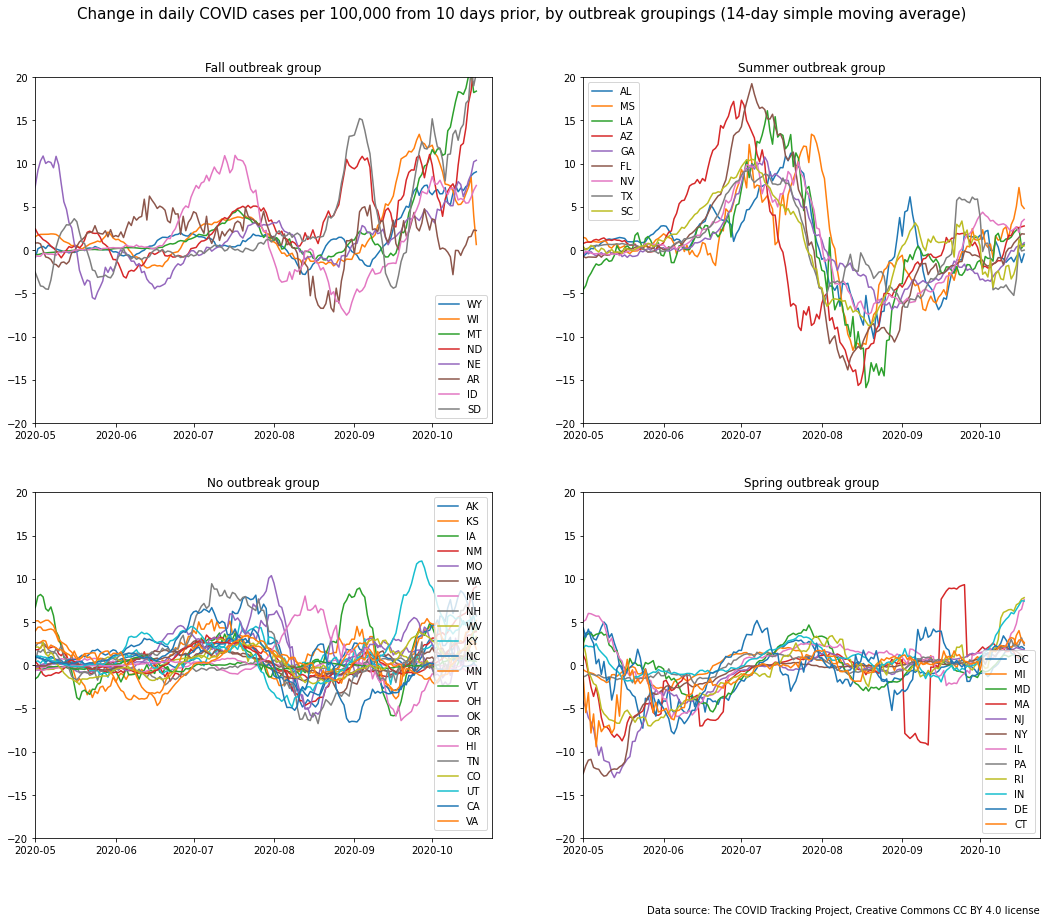

In [240]:
# Case rate change by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Change in daily COVID cases per 100,000 from 10 days prior, by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['case_SMA_10_day_change'], label = chart_state)
#     ax[i//2][i%2].axhline(y=20, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 5, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([-20,20])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1

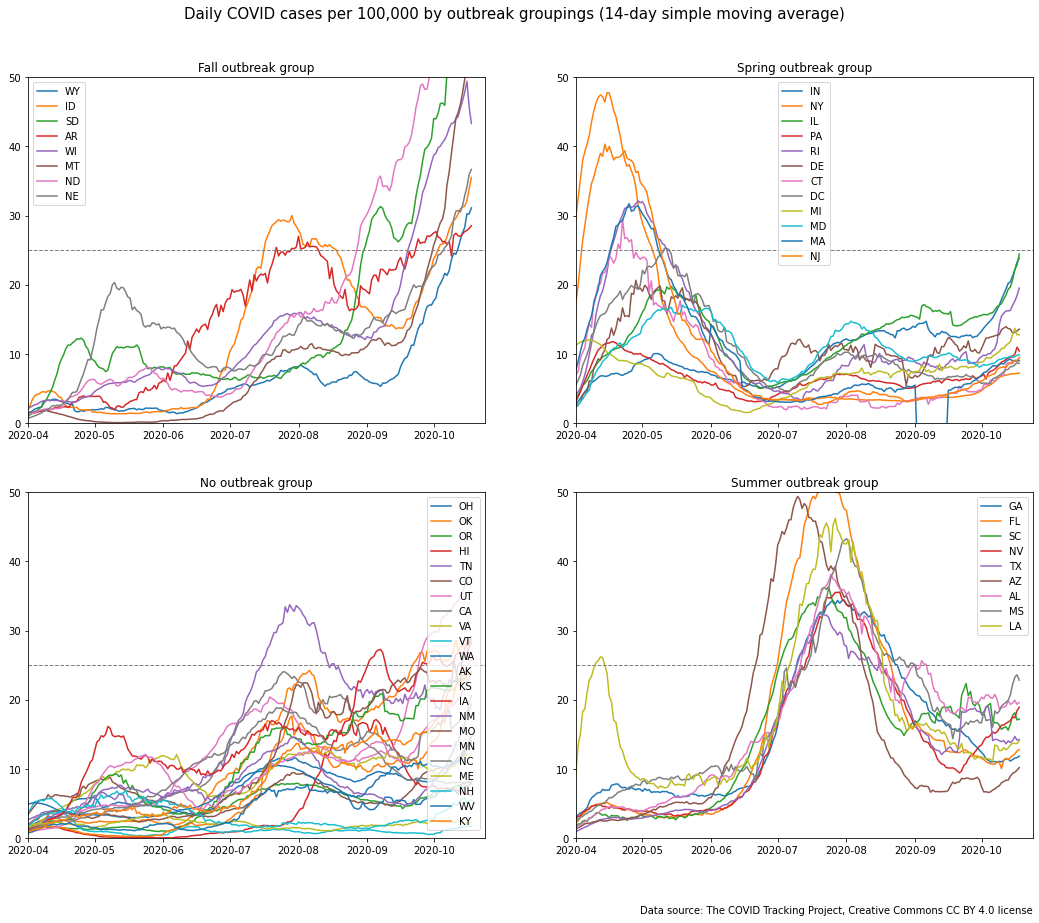

In [214]:
# Cases per 100,000 by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['case_SMA'], label = chart_state)
    ax[i//2][i%2].axhline(y=25, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,50])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1

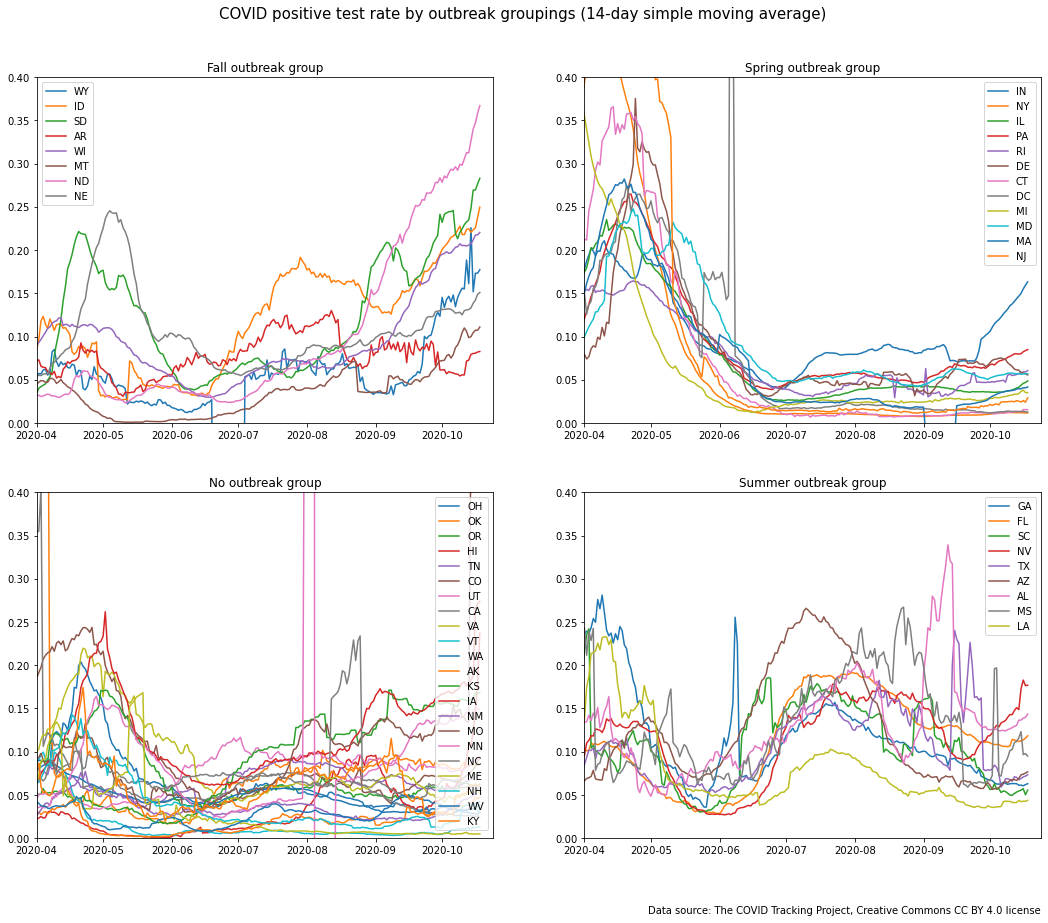

In [211]:
# Positive test rate by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['positive_test_rate'], label = chart_state)
    ax[i//2][i%2].axhline(y=20, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,0.4])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1

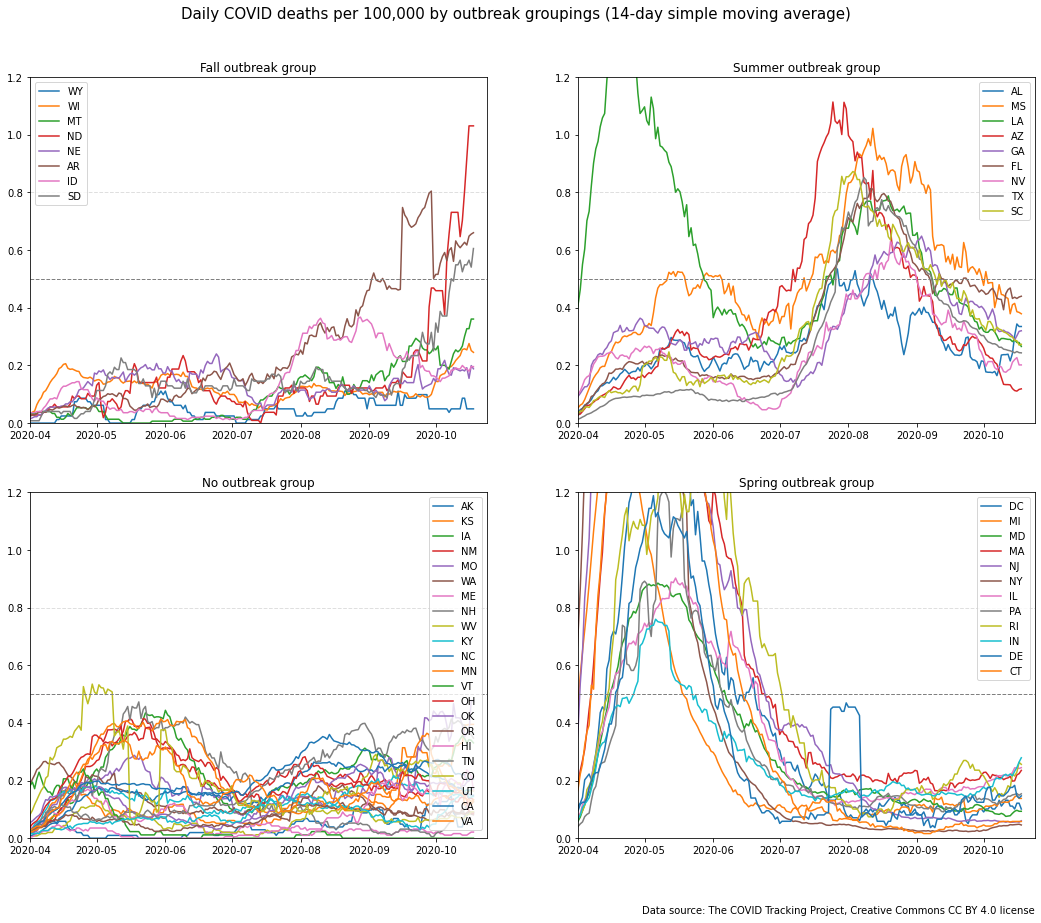

In [229]:
# Deaths per 100,000 by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID deaths per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['death_SMA'], label = chart_state)
    ax[i//2][i%2].axhline(y=0.8, ls= '--', lw=1, color = 'gray', alpha=0.25)
    ax[i//2][i%2].axhline(y=0.5, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,1.2])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1

In [167]:
first, last = (18,20)

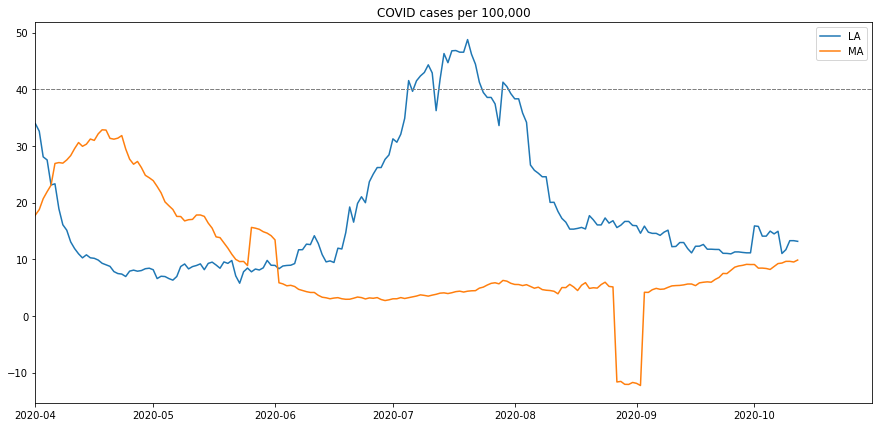

In [168]:
# Cases per 100,000 by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=7).mean()
    ax.plot(state_df['date'], state_df['case_SMA'] / state_df['Population'] * 100000, label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_title(f'COVID cases per 100,000')
    ax.axhline(y=40, ls= '--', lw=1, color = 'gray')
    ax.legend()

In [76]:
chart_state = 'WA'
state_df = df_state[df_state['state']== chart_state]
state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
temp_state_df = state_df[['date', 'death_SMA']]
temp_state_df['date'] = temp_state_df['date'] - timedelta(days=21)
state_df = state_df.merge(temp_state_df, on='date')

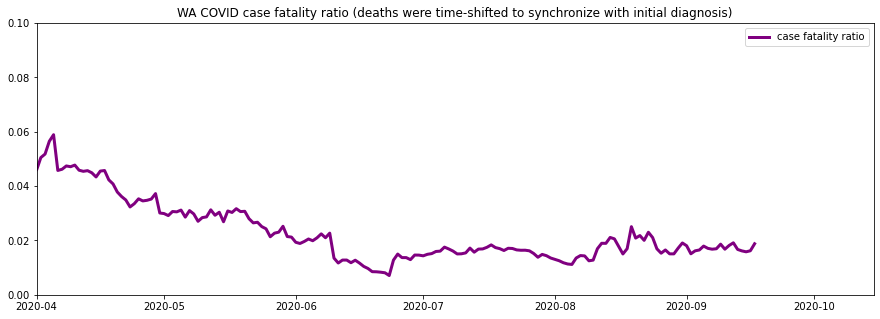

In [52]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = 'case fatality ratio', color = 'purple', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_ylim(0, 0.1)
ax.set_title(f'{chart_state} COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
ax.legend()

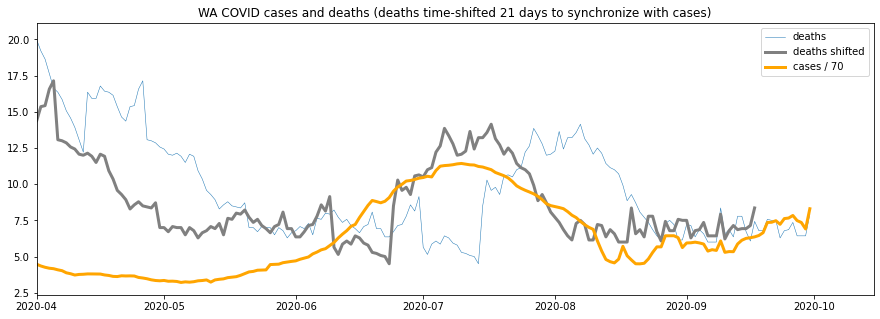

In [53]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_x'], label = 'deaths', lw= .5)
ax.plot(state_df['date'], state_df['death_SMA_y'], label = 'deaths shifted', color = 'gray', lw=3)
ax.plot(state_df['date'], state_df['case_SMA'] / 70, label = 'cases / 70', color = 'orange', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_title(f'{chart_state} COVID cases and deaths (deaths time-shifted 21 days to synchronize with cases)')
ax.legend()

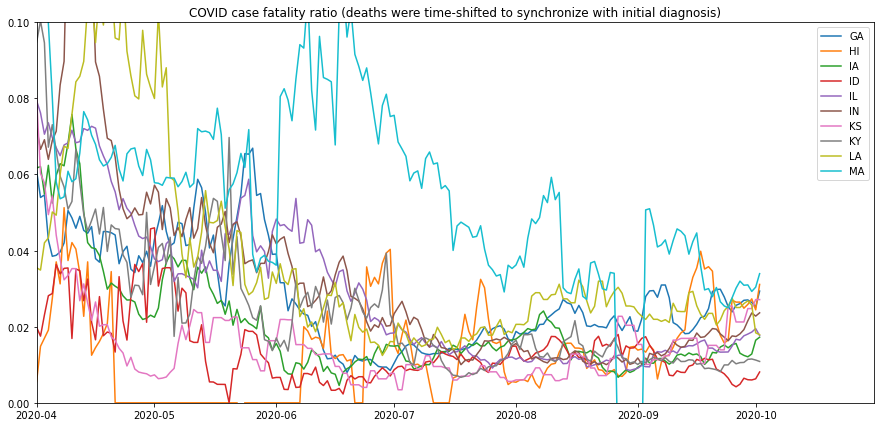

In [82]:
# Case fatality ratio by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=7).mean()
    state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=7).mean()
    temp_state_df = state_df[['date', 'death_SMA']]
    temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
    state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_ylim(0, 0.1)
    ax.set_title(f'COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()